# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» 
внедряет систему компьютерного зрения для обработки фотографий покупателей.\
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем необходимые библиотеки

In [2]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Загрузим данные 

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Размер выборки - 7591

Посмотри на загруженные данные

In [17]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Посмотрим статистики данных

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Средний возраст в выборке - 31.2 года, медианный возраст - 29 лет

Построим график распределения возраста

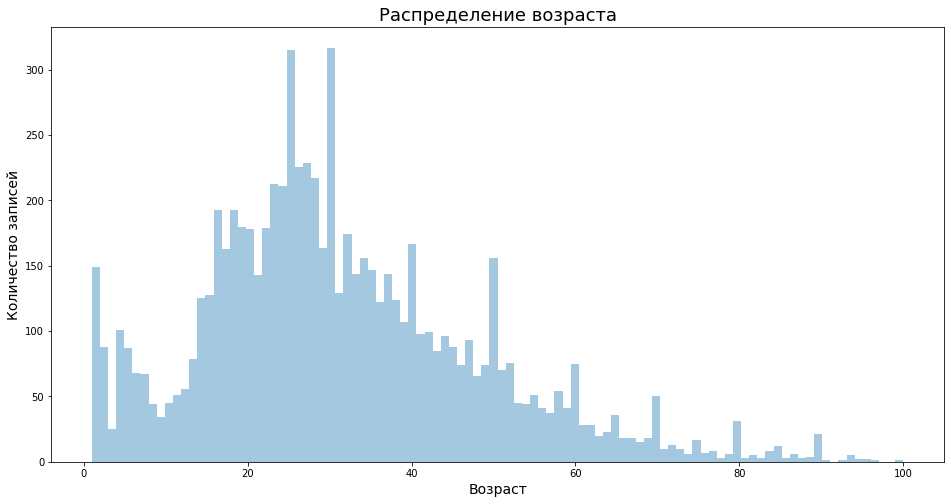

In [7]:
plt.figure(figsize=(16,8))
sns.distplot(labels['real_age'], bins=100, kde=False)
plt.title("Распределение возраста", fontsize=18)
plt.ylabel('Количество записей', fontsize=14)
plt.xlabel('Возраст', fontsize=14)
plt.show();

Распределение похоже на нормальное, но с увеличенным количестом записей с 0 до 10 лет.

Выведем на экран 16 фотографий из датасета

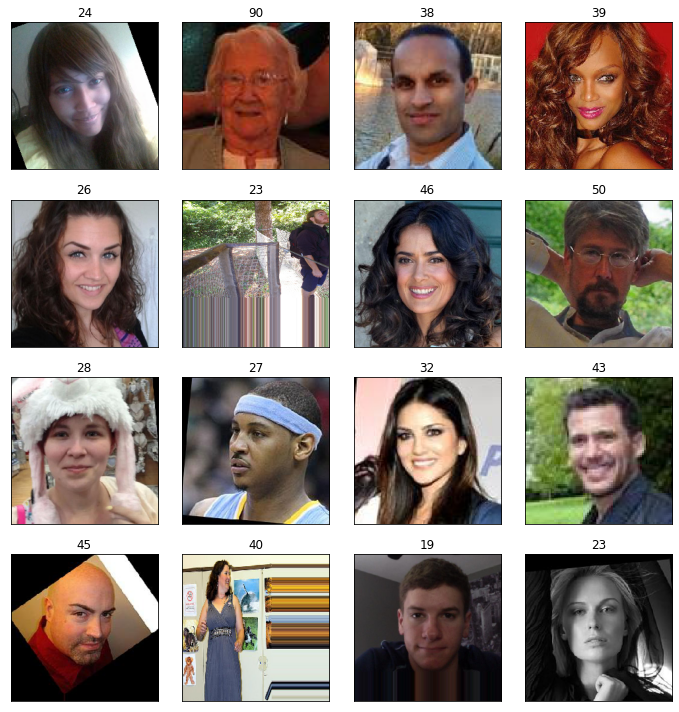

In [14]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    

### Вывод: 
1) Загрузили данные - 7591 запись;\
2) Средний возраст в выборке - 31.2 года, медианный возраст - 29 лет;\
3) Распределение данных похоже на нормальное, но с увеличенным количестом записей с 0 до 10 лет;\
4) Загрузили 16 фотографий из данных.

## Обучение модели

In [7]:
def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        horizontal_flip=True,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [8]:
def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

In [9]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 \

190/190 - 97s - loss: 281.9189 - mae: 11.7614 - val_loss: 935.2146 - val_mae: 25.6253\
Epoch 2/10\
190/190 - 39s - loss: 79.3237 - mae: 6.6761 - val_loss: 834.9103 - val_mae: 23.6355\
Epoch 3/10\
190/190 - 38s - loss: 54.6241 - mae: 5.5534 - val_loss: 198.0363 - val_mae: 10.2846\
Epoch 4/10\
190/190 - 40s - loss: 36.8734 - mae: 4.6286 - val_loss: 101.0045 - val_mae: 7.5935\
Epoch 5/10\
190/190 - 42s - loss: 28.0033 - mae: 4.0579 - val_loss: 78.6986 - val_mae: 6.6624\
Epoch 6/10\
190/190 - 42s - loss: 22.7461 - mae: 3.6421 - val_loss: 95.0628 - val_mae: 7.1819\
Epoch 7/10\
190/190 - 43s - loss: 18.1808 - mae: 3.2665 - val_loss: 63.0941 - val_mae: 6.0683\
Epoch 8/10\
190/190 - 42s - loss: 15.0558 - mae: 2.9708 - val_loss: 63.6811 - val_mae: 5.9825\
Epoch 9/10\
190/190 - 42s - loss: 12.2741 - mae: 2.6734 - val_loss: 59.5541 - val_mae: 5.7848\
Epoch 10/10\
190/190 - 40s - loss: 10.4524 - mae: 2.4700 - val_loss: 65.0696 - val_mae: 6.0018\
WARNING:tensorflow:sample_weight modes were coerced from\
  ...\
    to  \
  ['...']\
48/48 - 8s - loss: 65.0696 - mae: 6.0018\
Test MAE: 6.0018

## Анализ обученной модели

1) Обучили модель ResNet50;\
2) Получили значение MAE на тестовой выборке - 6.79;\
3) После 9 эпохи MAE на валидационной выборке начинает расти, что может свидетельствовать о начале переобучения. 

## Общий вывод 

1) Загрузили данные - 7591 запись;\
2) Средний возраст в выборке - 31.2 года, медианный возраст - 29 лет;\
3) Распределение данных похоже на нормальное, но с увеличенным количестом записей с 0 до 10 лет;\
4) Загрузили 16 фотографий из данных;\
5) Обучили модель ResNet50;\
6) Получили значение MAE на тестовой выборке - 6.32;\
7) После 9 эпохи MAE на валидационной выборке начинает расти, что может свидетельствовать о начале переобучения;\
8) Полученная модель позволяет определить возраст достаточно точно, для категоризации покупателей по возрастным группам. 